# Add batch effects

Say we are interested in identifying genes that differentiate between disease vs normal states.  However our dataset includes samples from different tissues or time points and there are variations in gene expression that are due to these other conditions and do not have to do with disease state.  These non-relevant variations in the data are called *batch effects*.  

We want to model these batch effects.  To do this we will:
1. Partition our simulated data into n batches
2. For each partition we will randomly shift the expression data.  We randomly generate a binary vector of length=number of genes (*offset vector*).  This vector will serve as the direction that we will shift to.  Then we also have a random scalar that will tell us how big of a step to take in our random direction (*stretch factor*).  We shift our partitioned data by: batch effect partition = partitioned data + stretch factor * offset vector
3. Repeat this for each partition
4. Append all batch effect partitions together


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap
import pickle
import warnings
warnings.filterwarnings(action='once')

from ggplot import *
from sklearn.decomposition import PCA
from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Parameters
analysis_name = 'experiment_1'
NN_architecture = 'NN_2500_20'
num_simulations = 10
num_batches = [1,2,3,4,5,6,7,8,9,10,15,20,50,100,500,800]

In [3]:
# Create directories
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

new_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('directory already exists: {}'.format(analysis_dir))
else:
    print('creating new directory: {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Batch_effects_simulation/data/batch_simulated/experiment_1


In [4]:
# Load arguments
simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

simulated_data_mapping_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "mapping_simulated_data.txt")

umap_model_file = umap_model_file = os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "umap_model.pkl")

In [5]:
# Read in UMAP model
infile = open(umap_model_file, 'rb')
umap_model = pickle.load(infile)
infile.close()

In [6]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0, 
    index_col=0,
    sep='\t')

simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.446957,0.643729,0.354168,0.581424,0.276973,0.303365,0.374227,0.460525,0.405243,0.180418,...,0.235136,0.524545,0.495369,0.411390,0.491835,0.293282,0.480864,0.436720,0.612998,0.492759
1,0.669778,0.644412,0.498653,0.610226,0.418455,0.443748,0.353707,0.550629,0.480056,0.200336,...,0.418858,0.586383,0.560669,0.533606,0.537233,0.255870,0.508560,0.578685,0.655122,0.641101
2,0.657138,0.730673,0.440241,0.702760,0.385269,0.373569,0.362133,0.483341,0.433026,0.161613,...,0.310219,0.546557,0.495103,0.451879,0.448654,0.215856,0.438995,0.432516,0.615505,0.548398
3,0.723734,0.667772,0.469858,0.684377,0.416712,0.502864,0.334403,0.576391,0.575824,0.185063,...,0.472288,0.635912,0.578134,0.661214,0.677254,0.272760,0.551928,0.716744,0.704614,0.743591
4,0.604745,0.631769,0.417092,0.606435,0.365324,0.366674,0.457452,0.484630,0.444616,0.186451,...,0.406186,0.518205,0.548476,0.535507,0.577210,0.214304,0.447972,0.475188,0.660519,0.617953
5,0.393833,0.441538,0.462849,0.413818,0.252220,0.329054,0.420920,0.414463,0.289230,0.257735,...,0.505044,0.532643,0.534202,0.388367,0.426247,0.321606,0.593928,0.454505,0.530716,0.486531
6,0.646332,0.666576,0.520155,0.660582,0.327622,0.420341,0.507159,0.520566,0.466660,0.173926,...,0.310077,0.514585,0.572118,0.409392,0.408634,0.152498,0.410186,0.357153,0.561198,0.523708
7,0.545069,0.538265,0.405931,0.492182,0.366361,0.400498,0.338944,0.489148,0.456469,0.214793,...,0.385395,0.512551,0.504046,0.507975,0.559667,0.334660,0.528677,0.524593,0.615336,0.620235
8,0.756644,0.690710,0.518062,0.669596,0.451826,0.367823,0.252145,0.686577,0.748654,0.196950,...,0.420365,0.612563,0.656352,0.619437,0.708211,0.184388,0.516549,0.667663,0.739598,0.741968
9,0.616562,0.644032,0.408858,0.621177,0.302901,0.304532,0.457121,0.511133,0.408189,0.180751,...,0.316074,0.527674,0.509688,0.428431,0.469661,0.217287,0.419857,0.415159,0.570727,0.569257


In [7]:
# Read in metadata
metadata = pd.read_table(
    simulated_data_mapping_file,
    header=0, 
    index_col=0,
    sep='\t')

metadata.head(10)

,metadata
0,PAO1
1,PAO1
2,PAO1
3,PAO1
4,PAO1
5,PAO1
6,PAO1
7,PAO1
8,PAO1
9,PAO1


In [8]:
# Replace NaN with string "NA"
metadata['metadata'] = metadata['metadata'].fillna('NA')

In [9]:
# Add batch effects
# ADD MULTIPLE SIMULATION RUNS
num_simulated_samples = simulated_data.shape[0]
num_genes = simulated_data.shape[1]
subset_genes_to_change = np.random.RandomState(randomState).choice([0, 1], size=(num_genes), p=[0, 1])
    
for i in num_batches:
    print('Creating simulated data with {} batches..'.format(i))
    
    batch_file = os.path.join(
            base_dir,
            "data",
            "batch_simulated",
            analysis_name,
            "Batch_"+str(i)+".txt")
    
    num_samples_per_batch = int(num_simulated_samples/i)
    
    if i == 1:        
        simulated_data.to_csv(batch_file, sep='\t')
        
    else:  
        batch_data_df = pd.DataFrame()
        for j in range(i):
            
            stretch_factor = np.random.uniform(0,1)
            
            # Randomly select samples
            batch_df = simulated_data.sample(n=num_samples_per_batch, frac=None, replace=False)

            # Add batch effect
            subset_genes_to_change_tile = pd.DataFrame(
                pd.np.tile(
                    subset_genes_to_change,
                    (num_samples_per_batch, 1)),
                index=batch_df.index,
                columns=list(simulated_data.columns))
            

            offset_vector = pd.DataFrame(subset_genes_to_change_tile*stretch_factor,
                                         columns=list(simulated_data.columns))
            batch_df = batch_df + offset_vector

            # if any exceed 1 then set to 1 since gene expression is normalized
            batch_df[batch_df>=1.0] = 1.0


            # Append batched together
            batch_data_df = batch_data_df.append(batch_df)

            # Select a new direction (i.e. a new subset of genes to change)
            np.random.shuffle(subset_genes_to_change)
            
        # Save
        batch_data_df.to_csv(batch_file, sep='\t')

Creating simulated data with 1 batches..
Creating simulated data with 2 batches..
Creating simulated data with 3 batches..
Creating simulated data with 4 batches..
Creating simulated data with 5 batches..
Creating simulated data with 6 batches..
Creating simulated data with 7 batches..
Creating simulated data with 8 batches..
Creating simulated data with 9 batches..
Creating simulated data with 10 batches..
Creating simulated data with 15 batches..
Creating simulated data with 20 batches..
Creating simulated data with 50 batches..
Creating simulated data with 100 batches..
Creating simulated data with 500 batches..
Creating simulated data with 800 batches..


## Plot batch data using UMAP

(1000, 5550)


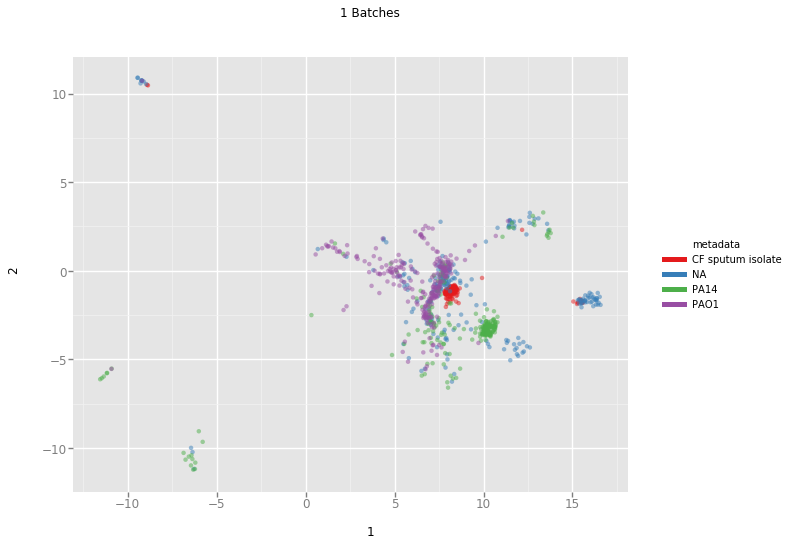

<ggplot: (8746692198653)>
(1000, 5550)


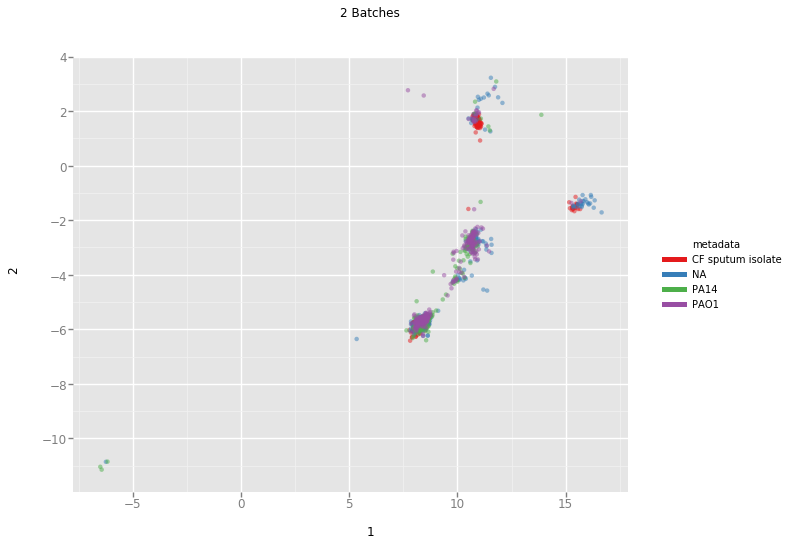

<ggplot: (-9223363290210107932)>
(999, 5550)


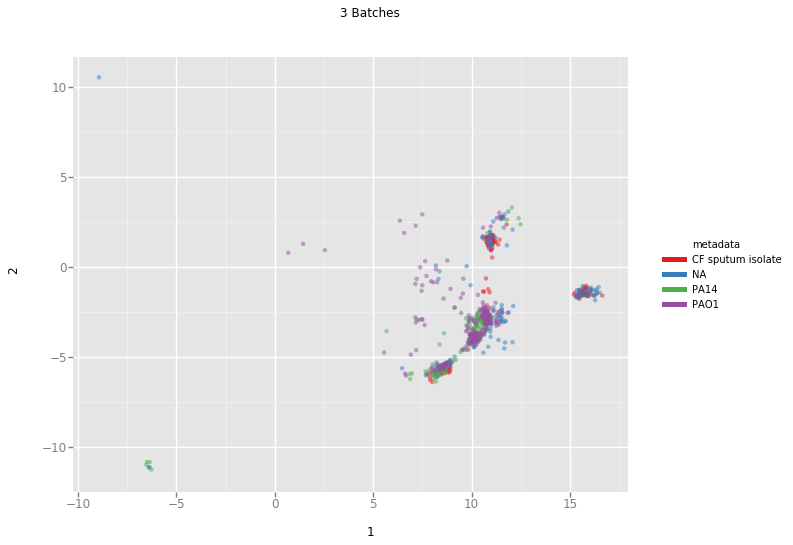

<ggplot: (8746644696128)>
(1000, 5550)


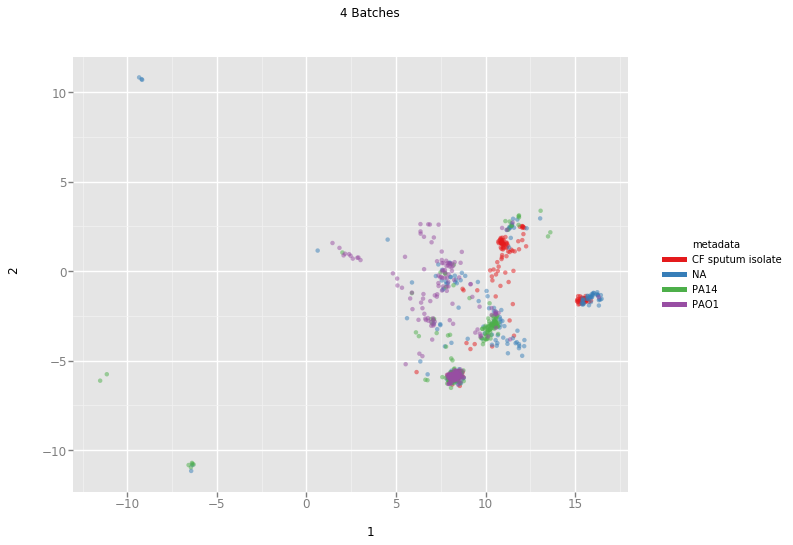

<ggplot: (8746644640944)>
(1000, 5550)


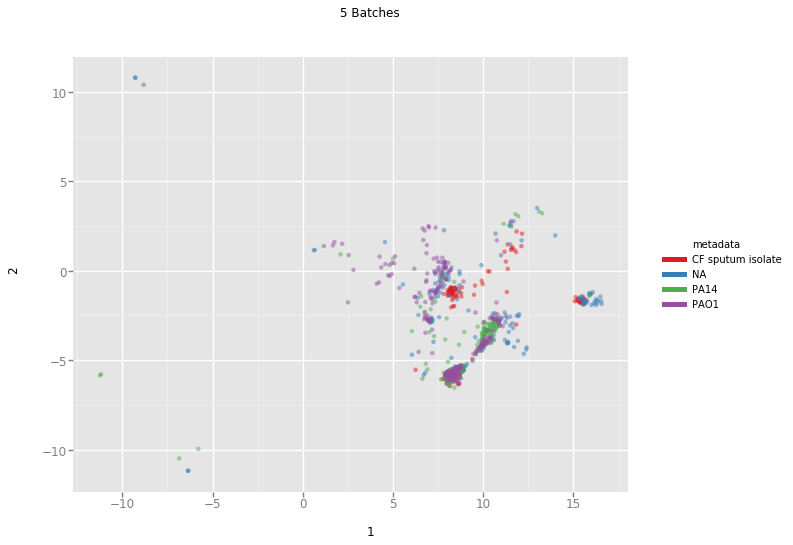

<ggplot: (-9223363290210146935)>
(996, 5550)


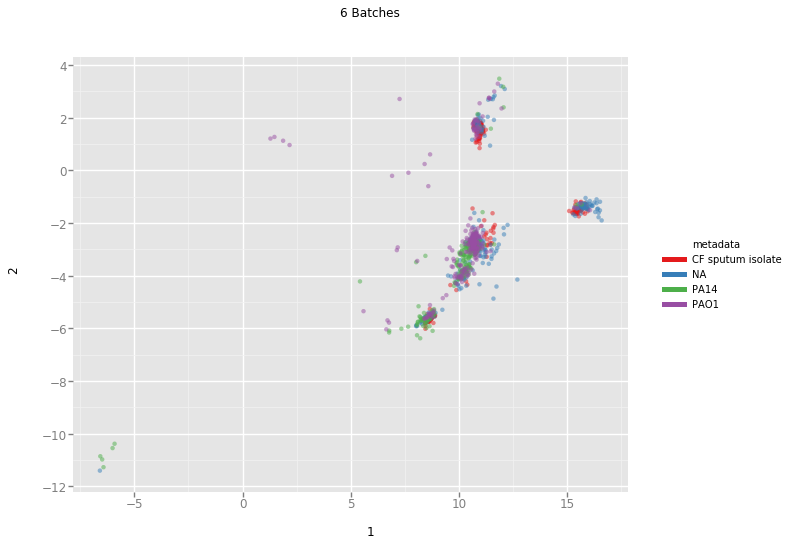

<ggplot: (8746644662115)>
(994, 5550)


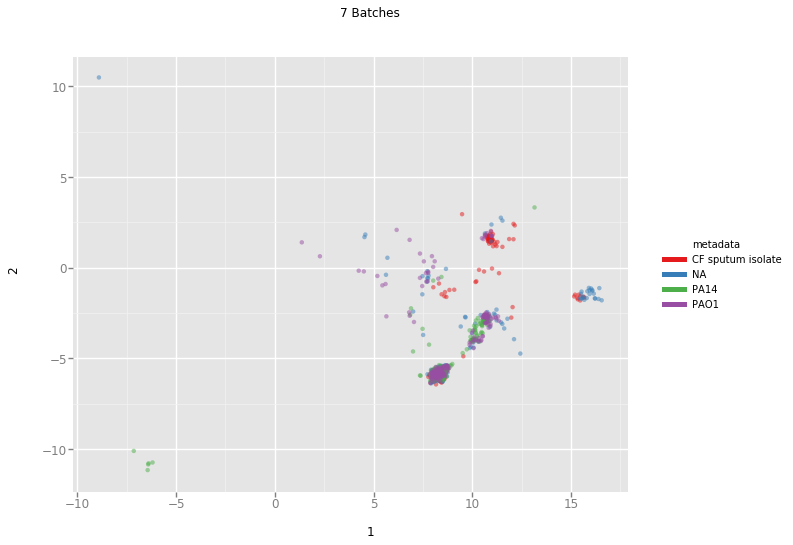

<ggplot: (8746644567083)>
(1000, 5550)


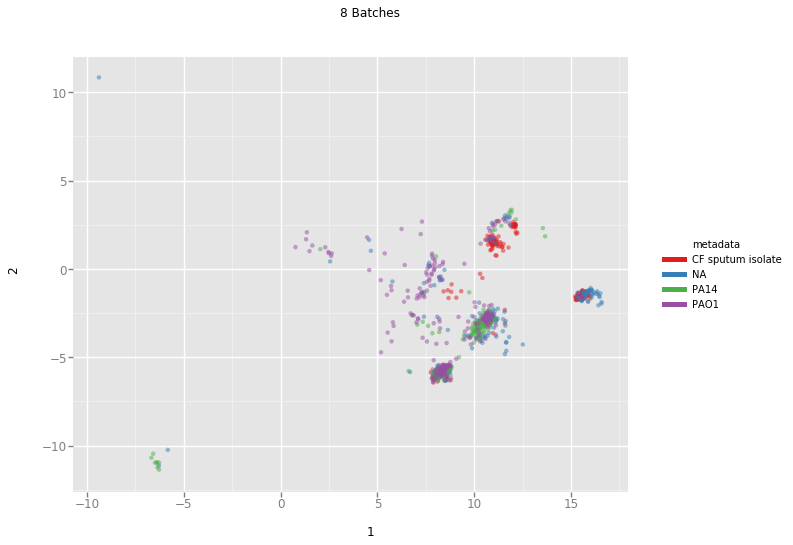

<ggplot: (-9223363290210941282)>
(999, 5550)


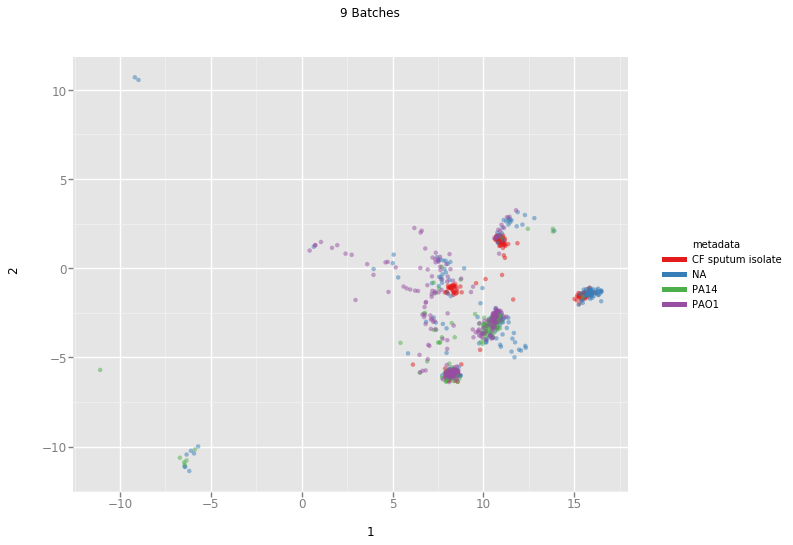

<ggplot: (8746643900024)>
(1000, 5550)


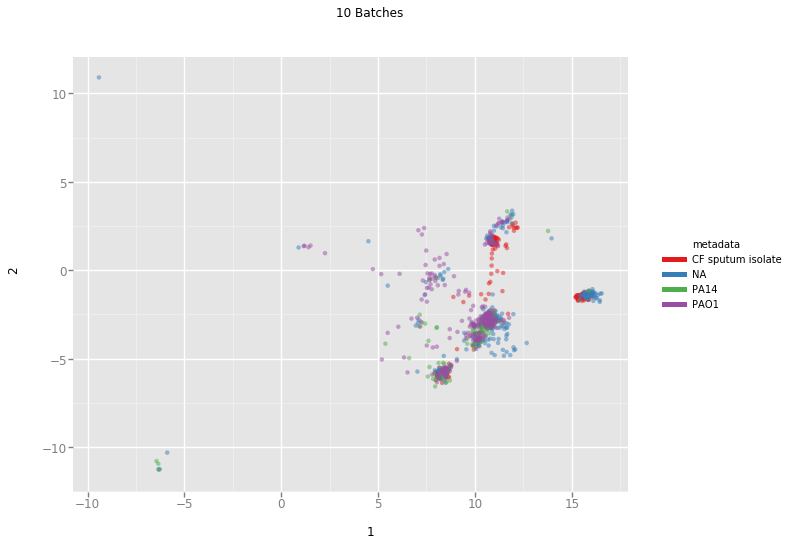

<ggplot: (-9223363290210935138)>
(990, 5550)


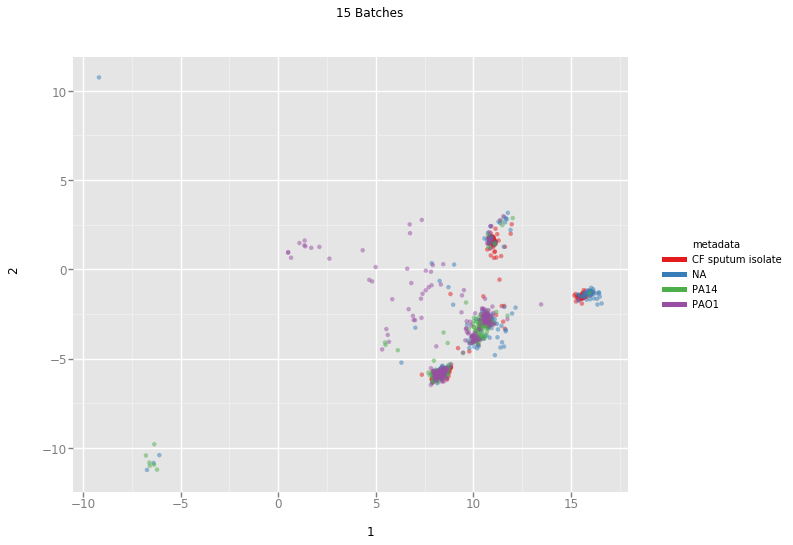

<ggplot: (8746644601208)>
(1000, 5550)


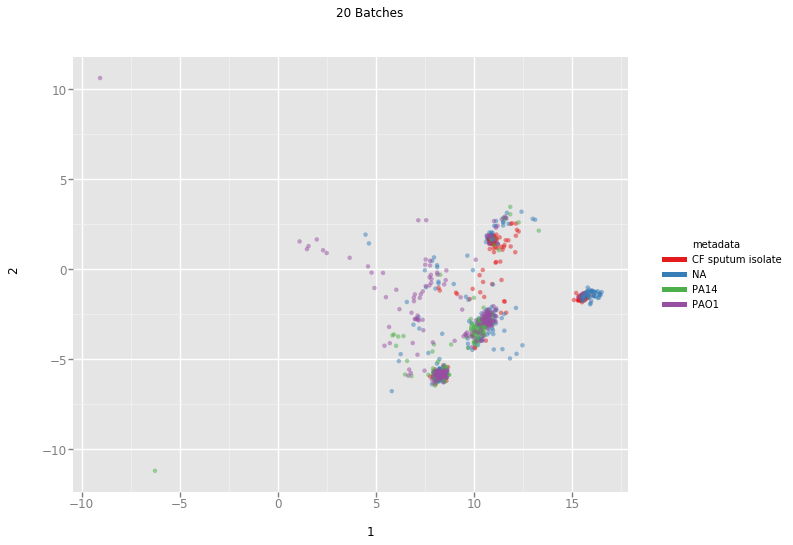

<ggplot: (8746692148551)>
(1000, 5550)


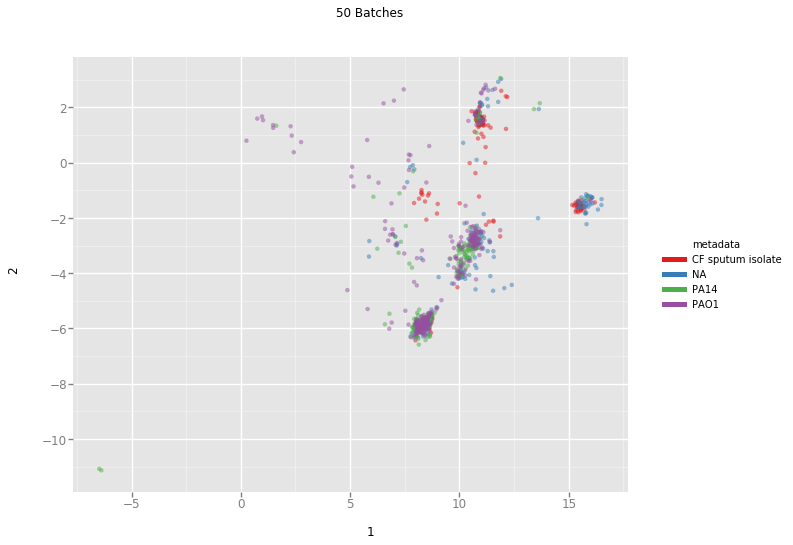

<ggplot: (8746692318959)>
(1000, 5550)


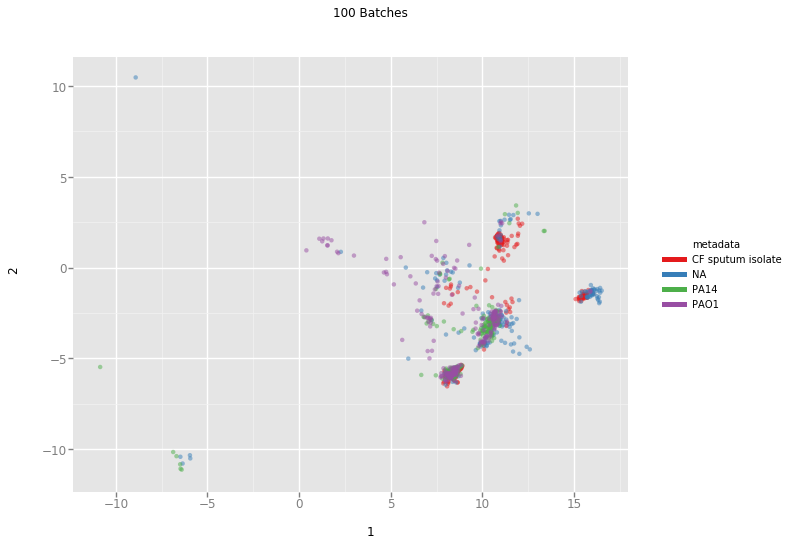

<ggplot: (-9223363290211756670)>
(1000, 5550)


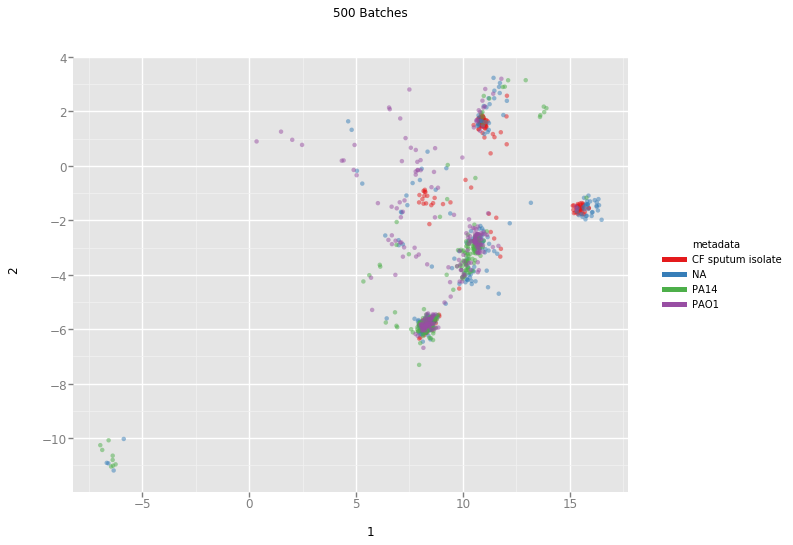

<ggplot: (8746642990838)>
(800, 5550)


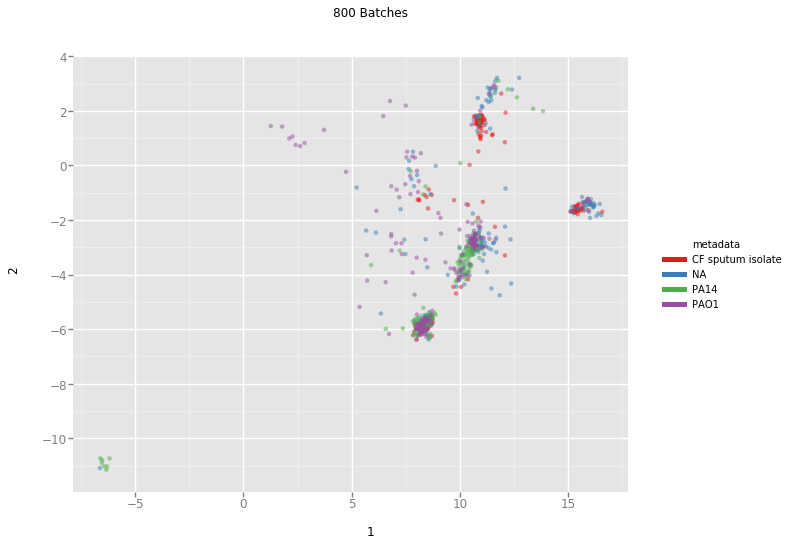

<ggplot: (8746644754794)>


In [10]:
# Plot generated data in UMAP 

for i in num_batches:
    batch_data_file = os.path.join(
        base_dir,
        "data",
        "batch_simulated",
        analysis_name,
        "Batch_"+str(i)+".txt")
    
    batch_data = pd.read_table(
        batch_data_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # Merge gene expression data and metadata
    batch_data_labeled = batch_data.merge(
        metadata,
        left_index=True, 
        right_index=True, 
        how='inner')

    print(batch_data_labeled.shape)
    
    # UMAP embedding of decoded batch data
    batch_data_UMAPencoded = umap_model.transform(batch_data_labeled.iloc[:,:-1])
    batch_data_UMAPencoded_df = pd.DataFrame(data=batch_data_UMAPencoded,
                                             index=batch_data_labeled.index,
                                             columns=['1','2'])
    batch_data_UMAPencoded_df['metadata'] = list(batch_data_labeled['metadata'])
    
        
    g = ggplot(aes(x='1',y='2', color='metadata'), data=batch_data_UMAPencoded_df) + \
                geom_point(alpha=0.5) + \
                scale_color_brewer(type='qual', palette='Set1') + \
                ggtitle("{} Batches".format(i))
    
    print(g)